# Base de Dados
Gerada a partir de 490 exames, são sinais sonoros provenientes de dopplers ultra sônicos fetais (Figura 8) de baixo custo, realizando o procedimento descrito na introdução.

![imagem](https://lh7-us.googleusercontent.com/oXQHWsfZ8nCHBnj_xXYQZb5JpZuPBAX1MdNWYJ7f_u0W4NXNKzeA6GRCcZQkaMcOBZ3aDBDqxp2YRL6smSyh4OTTqnMOqRS9xUJYL4bDfWahKcF4X2a82jM0kmZz5YBYRsq2qCbKnn5mDoR_VNLeE4M)

Figura 8 - Ultrassom Fetal comercial de baixo custo.


---
Pontos importantes sobre os arquivos existentes:

O doppler possui baixa filtragem a ruído, portanto o ruído de fundo é presente quase em todas as medidas;
Os arquivos não foram verificados, portanto existem arquivos que não são medições clínicas reais;
Existem medições sem nenhuma deglutição ou com muitos ruídos, sendo inválidos para uso;
O número de deglutições por medição pode variar de 1 a 4.

A base de dados está disponível para download no endereço abaixo:

https://drive.google.com/file/d/1z1sqrxP_Ozdcu3sKvJDN7GJIxrv5TXBu/view?usp=drive_link

## Libraries

In [ ]:
!pip install pydub

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob

import os
import joblib
from google.colab import drive

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pydub import AudioSegment
import librosa
from scipy.signal import find_peaks

from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf

## Drive e dados

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/ECOM09A/Atividade_1/ConsultasDataset.zip" .


In [ ]:
!unzip ConsultasDataset.zip

Archive:  ConsultasDataset.zip
   creating: ConsultasDataset/
   creating: ConsultasDataset/labels/
   creating: ConsultasDataset/labels/invalidos/
  inflating: ConsultasDataset/labels/invalidos/a00188.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00002.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00010.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00016.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00020.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00021.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00023.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00024.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00025.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00028.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00041.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00048.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00049.mp3  
  inflating: ConsultasDataset/labels/invalidos/a00050.mp3  
  inflating:

#Extração de caracterisitcas


In [ ]:
mp3_files = [f for f in os.listdir("/content/ConsultasDataset/MP3/") if f.endswith('.mp3')]

In [ ]:
mp3s = glob.glob('/content/ConsultasDataset/MP3/*.mp3')

In [ ]:
def add_white_noise(x, rate=0.00):
    return x + rate*np.random.randn(len(x))

def time_shift(x, rate=2):
    return np.roll(x, int(len(x)//rate))

def pitch_shift(x, sr, n_steps):
    return librosa.effects.pitch_shift(x, sr, n_steps)

def time_stretch(x, rate=0.8):
    return librosa.effects.time_stretch(x, rate)

def reverse(x):
    return x[::-1]

In [ ]:
# Extração de recursos e aumento de dados
features = []
for file in tqdm(mp3s):
    y, sr = librosa.load(os.path.join("/content/ConsultasDataset/MP3/", file))

    # Aumento de dados
    y_noise = add_white_noise(y)
    y_shift = time_shift(y)
    y_reverse = reverse(y)

    # Extração de recursos
    for augmented_y in [y, y_noise, y_shift, y_reverse]:
        duration = librosa.get_duration(y=augmented_y, sr=sr)
        spectral_centroids = librosa.feature.spectral_centroid(y=augmented_y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=augmented_y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=augmented_y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=augmented_y, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(augmented_y)
        mfcc = librosa.feature.mfcc(y=augmented_y, sr=sr)
        rmse = librosa.feature.rms(y=augmented_y)
        chroma_stft = librosa.feature.chroma_stft(y=augmented_y, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=augmented_y, sr=sr)
        melspectrogram = librosa.feature.melspectrogram(y=augmented_y, sr=sr)

        # Calculando np.mean, np.std e np.ptp
        features_dict = {}
        for feature, feature_name in zip([spectral_centroids, spectral_contrast, spectral_bandwidth, spectral_rolloff, zero_crossing_rate, mfcc, rmse, chroma_stft, tonnetz, melspectrogram],
                                         ['spectral_centroids', 'spectral_contrast', 'spectral_bandwidth', 'spectral_rolloff', 'zero_crossing_rate', 'mfcc', 'rmse', 'chroma_stft', 'tonnetz', 'melspectrogram']):
            mean = np.mean(feature, axis=1)
            std = np.std(feature, axis=1)
            ptp = np.ptp(feature, axis=1)

            # Descompactando os vetores em colunas separadas
            for i in range(len(mean)):
                features_dict[f'{feature_name}_mean_{i}'] = mean[i]
                features_dict[f'{feature_name}_std_{i}'] = std[i]
                features_dict[f'{feature_name}_ptp_{i}'] = ptp[i]

        # Adicionando nome do arquivo e duração
        features_dict['file'] = file
        features_dict['duration'] = duration

        features.append(features_dict) # Criar DataFrame


100%|██████████| 490/490 [25:16<00:00,  3.10s/it]


In [ ]:
df = pd.DataFrame(features)
df.to_csv("database.csv", index=False)

In [ ]:
df['file'] = df['file'].apply(lambda x: x.split('/')[-1])

In [ ]:
df.head(10)

,spectral_centroids_mean_0,spectral_centroids_std_0,spectral_centroids_ptp_0,spectral_contrast_mean_0,spectral_contrast_std_0,spectral_contrast_ptp_0,spectral_contrast_mean_1,spectral_contrast_std_1,spectral_contrast_ptp_1,spectral_contrast_mean_2,...,melspectrogram_ptp_125,melspectrogram_mean_126,melspectrogram_std_126,melspectrogram_ptp_126,melspectrogram_mean_127,melspectrogram_std_127,melspectrogram_ptp_127,file,duration,valid
0,1731.058284,335.622390,1898.014062,22.745991,4.557550,40.922714,10.487578,3.227850,27.333287,12.420757,...,0.000203,0.000042,0.000016,0.000102,0.000004,0.000002,0.000010,a00299.mp3,14.882540,True
1,2558.297363,463.083740,2773.123755,21.869725,4.523453,40.755000,10.416972,3.099111,26.726065,12.460622,...,0.000531,0.000330,0.000075,0.000506,0.000289,0.000065,0.000381,a00299.mp3,14.882540,True
2,1731.036693,335.021600,1874.092648,22.723278,4.656667,37.843531,10.319537,3.115737,20.041797,12.466053,...,0.000185,0.000042,0.000016,0.000105,0.000004,0.000002,0.000011,a00299.mp3,14.882540,True
3,1730.988421,335.629842,1899.044939,22.667303,4.343119,35.584263,10.313337,3.051407,25.577430,12.424516,...,0.000200,0.000042,0.000016,0.000104,0.000004,0.000002,0.000011,a00299.mp3,14.882540,True
4,1705.318650,598.164378,2043.224835,20.783292,5.498146,33.368418,10.234230,3.021841,19.035063,12.706258,...,0.000299,0.000040,0.000020,0.000358,0.000003,0.000002,0.000022,a00336.mp3,12.759365,True
5,2688.903518,927.351370,3301.482894,19.160563,5.708551,32.665631,10.264590,3.155777,21.278863,12.806039,...,0.000571,0.000328,0.000077,0.000485,0.000287,0.000063,0.000411,a00336.mp3,12.759365,True
6,1705.413977,598.454106,2041.194292,20.428826,5.385856,29.709713,10.180325,2.927769,20.981910,12.960921,...,0.000296,0.000040,0.000020,0.000350,0.000003,0.000002,0.000025,a00336.mp3,12.759365,True
7,1706.303960,597.127238,2028.064351,20.367139,5.332193,32.779414,10.161685,2.943416,21.872014,12.784424,...,0.000270,0.000040,0.000020,0.000295,0.000003,0.000002,0.000028,a00336.mp3,12.759365,True
8,2234.958216,321.914188,2516.059072,23.059634,4.503320,44.607964,10.941250,2.949731,22.838219,13.212523,...,0.000664,0.000063,0.000037,0.000434,0.000006,0.000004,0.000053,a00039.mp3,18.153651,True
9,3056.396420,432.929941,3184.928102,22.159878,4.503068,34.228873,10.876748,2.936554,24.162325,13.277741,...,0.000715,0.000345,0.000095,0.001024,0.000289,0.000069,0.000426,a00039.mp3,18.153651,True


# Detecção de anomalia


In [ ]:
features_norm = df.drop('file', axis=1).values

In [ ]:
# Treinar modelo de detecção de anomalias
model = IsolationForest(random_state=42, contamination=0.32)
predictions = model.fit_predict(features_norm)

df['valid'] = predictions == 1

In [ ]:
# Save the model to a file
joblib.dump(model, 'model.joblib')

['model.joblib']

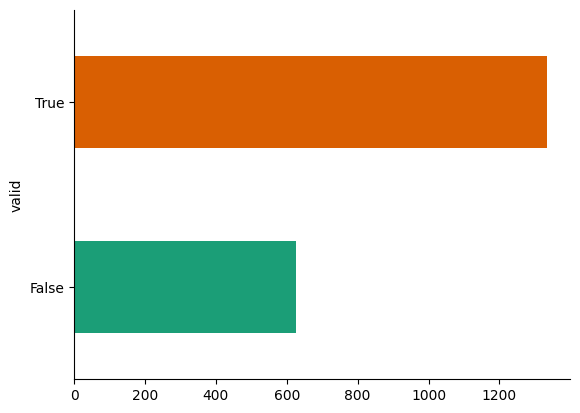

In [ ]:
df.groupby('valid').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

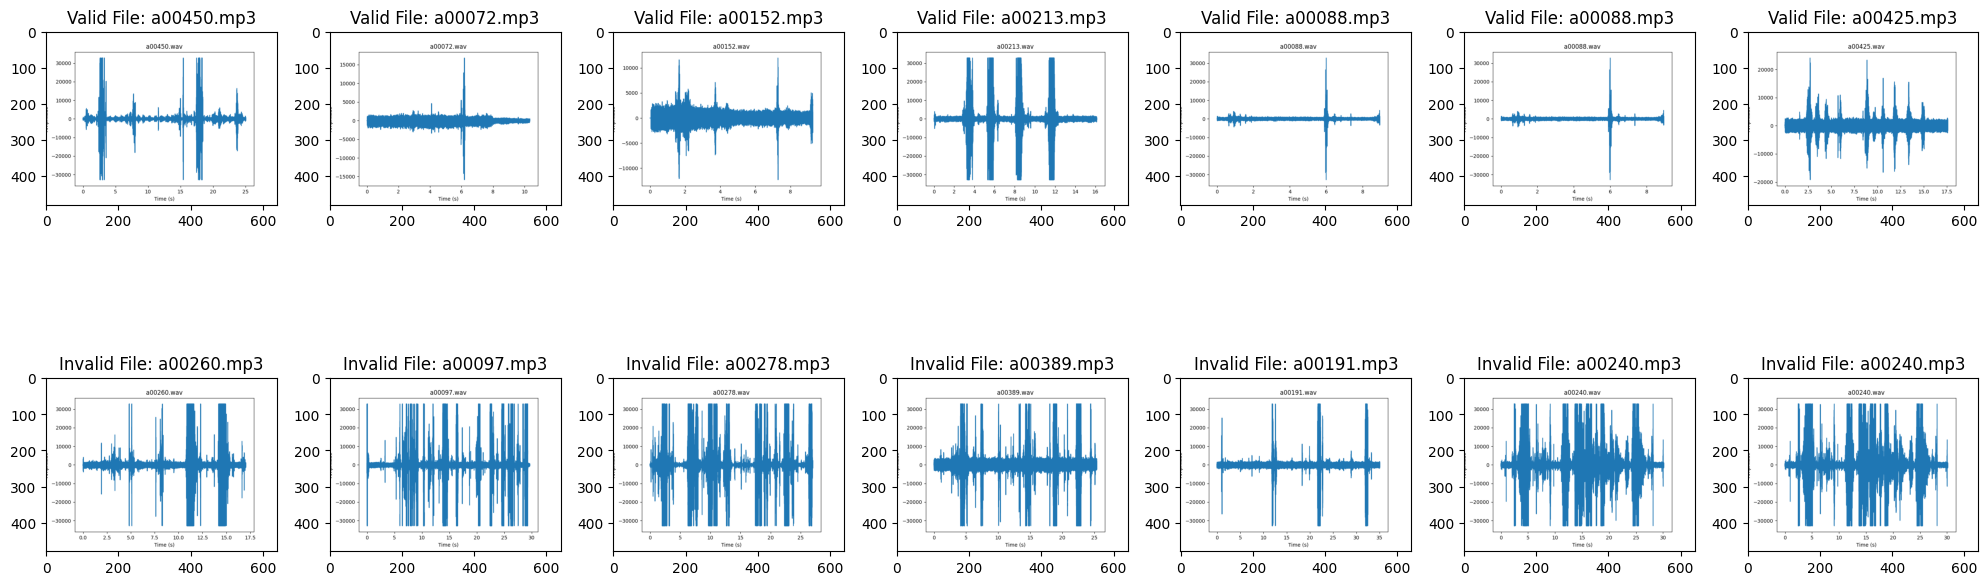

In [ ]:
# Selecione alguns arquivos válidos e inválidos
valid_files = df[df['valid']]['file'].sample(7)
invalid_files = df[~df['valid']]['file'].sample(7)

fig, axs = plt.subplots(2, 7, figsize=(20, 8))

# Plot gráficos para arquivos válidos
for i, file in enumerate(valid_files):
    img = mpimg.imread(os.path.join("/content/ConsultasDataset/Charts", file.replace('.mp3', '.png')))
    axs[0, i].imshow(img)
    axs[0, i].set_title(f'Valid File: {file}')

# Plot gráficos para arquivos inválidos
for i, file in enumerate(invalid_files):
    img = mpimg.imread(os.path.join("/content/ConsultasDataset/Charts", file.replace('.mp3', '.png')))
    axs[1, i].imshow(img)
    axs[1, i].set_title(f'Invalid File: {file}')

plt.tight_layout()
plt.show()



In [ ]:
# Carregar arquivos de áudio rotulados manualmente
valid_files = [f for f in os.listdir("/content/ConsultasDataset/labels/validos") if f.endswith('.mp3')]
invalid_files = [f for f in os.listdir("/content/ConsultasDataset/labels/invalidos") if f.endswith('.mp3')]

# Criar coluna de rótulos verdadeiros
df['true_label'] = df['file'].apply(lambda x: True if x in valid_files else False if x in invalid_files else -1)

# Filtrar as linhas onde temos rótulos verdadeiros
df_labeled = df[df['true_label'] != -1]
df_labeled.shape[0]


1960

In [ ]:
print(classification_report(df_labeled['true_label'], df_labeled['valid']))

              precision    recall  f1-score   support

       False       0.77      0.45      0.57      1076
        True       0.56      0.84      0.67       884

    accuracy                           0.62      1960
   macro avg       0.66      0.64      0.62      1960
weighted avg       0.67      0.62      0.61      1960



# **Supervisioned**

In [ ]:
# Drop the 'valid' column
df = df.drop('valid', axis=1)

In [ ]:
# Define the features and target variable
X = df.drop(['true_label', 'file'], axis=1)
y = df['true_label']

In [ ]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [ ]:
print(X_norm.shape)
print(y.shape)

(1960, 535)
(1960,)


## **Classic ML**

In [ ]:
# Define the models to test
models = [
    RandomForestClassifier(random_state=42, max_depth=5),
    GradientBoostingClassifier(random_state=42, max_depth=5),
    AdaBoostClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42, max_depth=5),
    XGBClassifier(random_state=42)
]

# Perform cross-validation for each model
results = []
for model in models:
    scores = cross_validate(model, X_norm, y, cv=5, scoring=['f1', 'recall', 'precision'], verbose=1)
    results.append({
        'model': model.__class__.__name__,
        'f1_score': scores['test_f1'].mean(),
        'recall': scores['test_recall'].mean(),
        'precision': scores['test_precision'].mean()
    })

In [ ]:
df_res = pd.DataFrame(results).sort_values('f1_score', ascending=False)
df_res

,model,f1_score,recall,precision
3,ExtraTreesClassifier,0.673396,0.746430,0.619223
1,GradientBoostingClassifier,0.655788,0.668490,0.647249
0,RandomForestClassifier,0.652513,0.701226,0.612758
4,XGBClassifier,0.626847,0.636832,0.621069
2,AdaBoostClassifier,0.625907,0.649294,0.606091


In [ ]:
model_best = df_res.iloc[0]['model']
joblib.dump(model_best, 'best_model.joblib')

['best_model.joblib']